# Import

In [5]:
#path_essentials = '/Users/Setup3-PC/Desktop/qudi/logic/setup3_logic/script_logic_essentials.py'
path_essentials = 'user_scripts/Timo/from_Simon/script_logic_essentials.py'
path_toolkit = 'user_scripts/Timo/own/logic_toolkit.py'
path_curdir = 'user_scripts/Timo/own/'
import os, time, sys
import numpy as np
from logic.pulsed.predefined_generate_methods.pentacene_methods import DeerAltModes
from logic.pulsed.sampling_functions import DDMethods

# import essentials via run
exec(open(path_essentials).read())
exec(open(path_toolkit).read())
# usual module imports
sys.path.append(path_curdir)


import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

# configure this notebook
config_matplotlib_jupyter()

memory_dict=OrderedDict()
print_welcome_msg()
0

0

[Wed Aug 11 10:25:15 2021] Hi, jupyter ready. working dir: C:\Users\Setup3-PC\Desktop\qudi


# Common parameters

In [23]:
# MW parameters
common_rabi_period = 125.8e-9#94.5e-9 # 87.0e-9 #118.1e-9 #M2 149.1e-9#760e-9#245.5e-9 #159.5e-9
common_mw_freq =  2813.7e6 #2732.0e6 # 2774.0e6# 2786.2e6 #2775.0e6#827.64e6 #M2 1503.592e6 #M15, 1507.455e6  #1507.747#7e6  #1503.336e6  #2656.5e6#NV M3 1.497129e9 #NV M2 1.503316e9 
#common_mw_freq = 2872e6 
common_mw_amp = 0.250

# Readout
# RELOAD logic_essentials and upload new seq when changing!
common_t_laser_pulsed = 3e-6   # for pulsed mes (non NI acq)
common_t_wait_pulsed = 1e-6
common_t_laser = None
common_t_laser_green_init = 3e-6
common_t_laser_red_read = 1000e-9

# Ramsey
common_mw_ramsey_offset = 1000e3   # Hz, detuning, 
common_mw_ramsey_off_from_calib = 0e3 #0.1e6 #[0.66e6, 0.72e6]   # Hz, detuning,taken for checking valid


# MFL XY8
gamma_n_c13 = 1.0705e3 * 2*np.pi # 13-C

b_str = f"B= {f_res_2_B_gauss(common_mw_freq):.2f} G from common_mw_freq"
print(b_str)
logger.info(b_str)

B= 20.11 G from common_mw_freq


# Library

## nb specific

In [11]:
def calc_nuclear_rabi_hfs_boost(B_gauss, ms=-1, n_nuc=15):
    # Chen (2015)
    # Sangtawesin (2016)
    
    if n_nuc == 14:
        q_quadro = -4.945e6
        a_par = -2.162e6 # 14-n
        a_perp = 2.62e6
        gamma_n = -0.308e3  
    elif n_nuc == 15:
        q_quadro = 0  # spin=1/2 has no quadropolar moment
        a_par = 3.03e6
        a_perp = 3.65e6
        gamma_n = 0.432e3
        
    else:
        raise ValueError("Can only be 14-N or 15-N")
        
    gamma_e = 2.8e6
    delta = 2.87e9
    
    if ms == -1:
        alpha = 1 + gamma_e/gamma_n* a_perp / (delta-gamma_e*B_gauss-a_par+gamma_n*B_gauss+q_quadro)
    else:
        raise ValueError("m_s can only be 0/1/-1")
    
    return abs(alpha)

def setup_ise_ramsey_dd_params(tau, n_tau, n_order_dd, f_rf, t_pi_rf, amp_rf=0.25, rf_ch='a_ch2', dd_type=DDMethods.SE,
                               t_laser=1e-6, mw_sweep_speed=3e12, f_ise_res=1e9, df_mw_sweep=30e6, amp_mw_sweep=0.25,
                               alternating=True, autosave=-1, red_readout=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'ise+ramsey+rf_dd'
    qmeas['experiment'] = 'pol_ramsey_rf_dd'
    
    if not red_readout:
        setup['laser_length'] = common_t_laser_pulsed
    else:
        qmeas['t_laser_init'] = common_t_laser_green_init
        qmeas['laser_read_ch'] = 'd_ch3'
        setup['laser_length'] = common_t_laser_red_read
    
    setup['wait_time'] = common_t_wait_pulsed

    qmeas['tau'] = tau
    qmeas['n_tau'] = n_tau
    qmeas['n_order_pi_rf'] = n_order_dd
    qmeas['dd_type'] = dd_type
    qmeas['f_rf'] = f_rf
    qmeas['t_pi_rf'] = t_pi_rf
    qmeas['amp_rf'] = amp_rf
    qmeas['rf_channel'] = rf_ch
    qmeas['t_laser'] = t_laser
    qmeas['mw_sweep_speed'] = mw_sweep_speed
    qmeas['amp_mw_sweep'] = amp_mw_sweep
    qmeas['f_ise_res'] = f_ise_res
    qmeas['df_mw_sweep'] = df_mw_sweep
    
    qmeas['measurement_time'] = 99999 
    qmeas['optimize_time'] = None
    qmeas['autosave_s'] = autosave
    
    qmeas['alternating'] = alternating
    
    return qmeas

def setup_deer_f_params(f_res, he_tau=200e-9, f_step=2e6, n_f=50, two_deer_pi=True, pi_len=None, read_phases='0, 180',
                       deer_ampl=None):
    qmeas=OrderedDict()
    qmeas['name'] = 'deer_spectrum'
    setup['laser_length'] = common_t_laser_pulsed
    setup['wait_time'] = common_t_wait_pulsed

    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.

    qmeas['measurement_time'] = 150000 
    qmeas['optimize_time'] = None
    
    qmeas['alternating'] = True
    qmeas['two_deer_pi'] = two_deer_pi
    qmeas['he_tau'] = he_tau
    if not deer_ampl:
        qmeas['deer_amp'] = common_mw_amp
    else:
        qmeas['deer_amp'] = deer_ampl
    if not pi_len:
        qmeas['pi_len'] = common_rabi_period/2
    else:
        qmeas['pi_len'] = pi_len
    
    qmeas['read_phase_degree'] = read_phases
    
    return qmeas

def setup_deer_rabi_params(deer_freq, tau_start=10e-9, tau_step=1e-6, n_tau=50, 
                      he_tau=300e-9, read_phases='0, 180', deer_ampl=None,
                      two_deer_pi=True):
    qmeas=OrderedDict()
    qmeas['name'] = 'deer_rabi'
    setup['laser_length'] = common_t_laser_pulsed
    setup['wait_time'] = common_t_wait_pulsed

    qmeas['tau_start'] = tau_start
    qmeas['num_of_taus'] = n_tau
    qmeas['tau_step'] = tau_step

    qmeas['measurement_time'] = 99999 
    qmeas['optimize_time'] = None
    

    qmeas['he_tau'] = he_tau
    qmeas['two_deer_pi'] = two_deer_pi
    if not deer_ampl:
        qmeas['deer_amp'] = common_mw_amp
    else:
        qmeas['deer_amp'] = deer_ampl
    qmeas['deer_freq'] = deer_freq

    
    qmeas['alternating'] = True
    qmeas['read_phase_degree'] = read_phases
    
    return qmeas


def setup_deer_params(deer_freq, tau_start=10e-9, tau_step=1e-6, n_tau=50, 
                      he_tau=300e-9, second_rabi_period=None,
                      two_deer_pi=True):
    qmeas=OrderedDict()
    qmeas['name'] = 'DEER'
    setup['laser_length'] = common_t_laser_pulsed
    setup['wait_time'] = common_t_wait_pulsed

    qmeas['tau_start'] = tau_start
    qmeas['num_of_points'] = n_tau
    qmeas['tau_step'] = tau_step

    qmeas['measurement_time'] = 99999 
    qmeas['optimize_time'] = None
    

    qmeas['he_tau'] = he_tau
    qmeas['two_deer_pi'] = two_deer_pi

    qmeas['deer_amp'] = common_mw_amp
    qmeas['deer_freq'] = deer_freq
    if not second_rabi_period:
        qmeas['second_rabi_period'] = common_rabi_period
    else:
        qmeas['second_rabi_period'] = second_rabi_period
   
    qmeas['alternating'] = True
    
    return qmeas


def setup_ramsey_deer_pi_params(f_deer, t_pi_deer, 
                                tau_start=100e-9, n_tau=1, tau_step=None,
                                alternating_mode=DeerAltModes.NVPi3Half,
                                two_deer_pi=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'Ramsey_deer_pi'
    qmeas['experiment'] = 'ramsey_deer_pi'
    setup['laser_length'] = common_t_laser_pulsed
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 50e-9
    else:
        qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    qmeas['alternating_mode'] = alternating_mode
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'sine'
     
    qmeas['f_mw_deer'] = f_deer
    qmeas['t_pi_deer'] = t_pi_deer
    qmeas['two_deer_pi'] = two_deer_pi
    
    return qmeas

def setup_podmr_deer_pi_params(f_res, f_deer, t_pi_deer, 
                               p_scale=10, p_scale_onlyperiod=1, f_step=0.1e6, n_f=50, t_pi_manual=None):
    # @param p_scale_onlyperiod: scales rabi period according to given power factor.
    #                            useful, if externally controlling poewr
    qmeas=OrderedDict()
    qmeas['name'] = 'pulsedodmr_deer_pi'
    qmeas['experiment'] = 'pulsedodmr_deer_pi'
    setup['laser_length'] = common_t_laser_pulsed
    setup['wait_time'] = common_t_wait_pulsed
    if t_pi_manual:
        qmeas['rabi_period'] = 2*t_pi_manual
    else:
        qmeas['rabi_period'] = common_rabi_period*p_scale*p_scale_onlyperiod
    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common_mw_amp/(p_scale)
        qmeas['deer_amplitude'] = common_mw_amp
    else:
        qmeas['microwave_amplitude'] = common_mw_amp
        qmeas['deer_amplitude'] = common_mw_amp
    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'
    
    qmeas['f_mw_deer'] = f_deer
    qmeas['t_pi_deer'] = t_pi_deer
    
    return qmeas



def run_deer_f(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer_f'
    do_experiment(experiment='deer_spectrum', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')

def run_deer(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer'
    do_experiment(experiment='DEER', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')


def run_deer_rabi(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer_rabi'
    do_experiment(experiment='deer_rabi', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')


    
def run_deer_pi_start(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer_pi_start'
    do_experiment(experiment='DEER_pi_start', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')

## Basics

In [14]:
import pickle
from scipy.optimize import curve_fit
from scipy.stats import poisson

def f_res_2_B_gauss(f_res):
    return abs(f_res-2.87e9)/2.8e6
    

def setup_podmr_params(f_res, p_scale=10, p_scale_onlyperiod=1, f_step=0.1e6, n_f=50, t_pi_manual=None):
    # @param p_scale_onlyperiod: scales rabi period according to given power factor.
    #                            useful, if externally controlling poewr
    qmeas=OrderedDict()
    qmeas['name'] = 'pulsedodmr'
    qmeas['experiment'] = 'pulsedodmr'
    setup['laser_length'] = common_t_laser_pulsed
    setup['wait_time'] = common_t_wait_pulsed
    if t_pi_manual:
        qmeas['rabi_period'] = 2*t_pi_manual
    else:
        qmeas['rabi_period'] = common_rabi_period*p_scale*p_scale_onlyperiod
    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common_mw_amp/(p_scale)
    else:
        qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'
    
    return qmeas



def setup_rabi_params(tau_step=None, p_scale=1):
    
    qmeas=OrderedDict()
    qmeas['name'] = 'rabi'
    qmeas['experiment'] = 'rabi'
    setup['laser_length'] = common_t_laser_pulsed
    
    if tau_step is None:   
        tau_step = 5e-9
    qmeas['tau_step'] = tau_step
    qmeas['tau_start'] = 0e-9
    qmeas['num_of_points'] = 50
    qmeas['microwave_frequency'] = common_mw_freq #+ 0.5*3.03e6
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common_mw_amp/(2.*p_scale)
    else:
        qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['measurement_time'] = None
    qmeas['optimize_time'] = None
    qmeas['freq_optimize_time'] = None
    
    #qmeas['fit_experiment'] = None  #'cosine'
    #qmeas['analysis_interval'] = 3
    #qmeas['n_sweeps'] = 5
    
    return qmeas

def setup_ramsey_params(tau_start=100e-9, n_tau=1, tau_step=None, alternating=False, read_phases='0, 180',
                       red_readout=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'Ramsey'
    qmeas['experiment'] = 'ramsey_s3p'
    if not red_readout:
        setup['laser_length'] = common_t_laser_pulsed
    else:
        qmeas['t_laser_init'] = common_t_laser_green_init
        qmeas['laser_read_ch'] = 'd_ch3'
        setup['laser_length'] = common_t_laser_red_read
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 50e-9
    else:
        qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = alternating
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'sine_decay'
        
    qmeas['read_phases_degree'] = read_phases
 
    return qmeas

def setup_hahn_params(tau_start=50e-9, n_tau=50, tau_step=0.5e-6, alternating=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'hahnecho'
    qmeas['experiment'] = 'hahnecho'
    setup['laser_length'] = common_t_laser_pulsed
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 50e-9
    else:
        qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'exp'
 
    return qmeas
    

def setup_xy8_tausweep_params(tau_start=100e-9, n_tau=20, tau_step=None, xy8_order=1, alternating=False):
    qmeas=OrderedDict()
    qmeas['experiment'] = 'xy8_tau'
    qmeas['name'] = 'xy8_tau'
    setup['laser_length'] = common_t_laser_pulsed
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    
    qmeas['xy8_order'] = xy8_order
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 100e-9
    else:
        qmeas['tau_step'] = tau_step
        
    
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = alternating
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'Lorentz dip'
 
    return qmeas

def setup_xy8_nsweep_params(tau=500e-9, n_n=20, xy8_start=1, xy8_step=1, alternating=False):
    qmeas=OrderedDict()
    qmeas['experiment'] = 'xy8_nsweep'
    qmeas['name'] = 'xy8_nsweep'
    setup['laser_length'] = common_t_laser_pulsed
    
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    
    qmeas['tau'] = tau
    qmeas['xy8_start'] = xy8_start
    qmeas['xy8_step'] = xy8_step

        
    
    qmeas['num_of_points'] = n_n
    qmeas['alternating'] = alternating
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_n > 1:
        qmeas['fit_experiment'] = 'sine_decay'
 
    return qmeas

def run_generic(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag=f"{mes_params['name']}"
    do_experiment(experiment=mes_params['experiment'], qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=generate_new, save_tag=save_tag, load_tag='')


def run_pdomr(mes_params, save_tag=None, generate_new=True):
    
    up_to = (mes_params['freq_start'] + mes_params['freq_step'] * mes_params['num_of_points'])
    laser_off()
    if save_tag is None:
        save_tag='pOdmr_{:.2f}_{:.2f}MHz'.format(mes_params['freq_start']/1e6, up_to/1e6)
    do_experiment(experiment='pulsedodmr', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')

def run_rabi(mes_params):
    laser_off()
    do_experiment(experiment='rabi', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='Rabi_'+str(round(mes_params['microwave_amplitude']*1000))+'mV',load_tag='')

def run_xy8_tausweep(mes_params):
    laser_off()
    do_experiment(experiment='xy8_tau', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='xy8-o={}_tau_'.format(mes_params['xy8_order']),load_tag='')

def run_xy8_nsweep(mes_params):
    laser_off()
    do_experiment(experiment='xy8_nsweep', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='xy8_tau={}_nsweep'.format(mes_params['tau']),load_tag='')

       
    
def run_ramsey(mes_params, n_sweeps_stop=0):
    
    if n_sweeps_stop > 0:
        # else don't stop by sweeps
        run_ramsey_pj_params['n_sweeps'] = n_sweeps_stop
    
    laser_off()
    do_experiment(experiment=mes_params['experiment'], qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_conventional_information, generate_new=True, save_tag='Ramsey',load_tag='')   
    
    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)
    
    else:
        mes = get_current_pulsed_mes()
        x = mes.signal_data[0]
        y = mes.signal_data[1]
        
    return (x,y)  


def create_temp_dir():
    #qudi_dir = os.getcwd()
    
    folder_dir = 'temp'
    try:
        os.mkdir(folder_dir)
    except FileExistsError as e:
        pass   # already exists
    
    return folder_dir 
    
def get_counts(t_avg_s=0.1):
    
    # stop refocusing for getting counts
    refocus_running = True
    try:
        if poimanagerlogic.time_until_refocus == -1:
            refocus_running = False
        else:
            poimanagerlogic.toggle_periodic_refocus(False)
    except NameError:
        refocus_running = False
        
    
    f_count = counterlogic.get_count_frequency()
    n_samples = int(t_avg_s * f_count)
    n_samples_max = counterlogic.get_count_length()
    if n_samples > n_samples_max:
        n_samples = n_samples_max
        
    # wait until refocus done for sure
    if refocus_running:
        timeout = False
        timeout_t_s = 5
        t_start = time.time()

        while(time.time() - poimanagerlogic._last_refocus < t_avg_s and not timeout):
            time.sleep(0.1)
            if time.time() - t_start > timeout_t_s:
                timeout = True
                
    cts = np.median(counterlogic.countdata[0][-n_samples:])    # counts per s
    
    if refocus_running:
        poimanagerlogic.toggle_periodic_refocus(True)
    
    return cts
        


# Laser options

## Optimize position

In [17]:
#laser_on()
optimize_position()

5.467545509338379

## Laser On

In [38]:
#laser_on(pulser_on = False)
laser_on()
counterlogic.startCount()

0

## Laser Off

In [35]:
laser_off(pulser_on=False)
#counterlogic.stopCount()


# Frequency Optimization parameters

In [ ]:
optimize_freq_dict=OrderedDict()
optimize_freq_dict['mw_optimization_method'] = 'pulsedodmr'
optimize_freq_dict['optimize_generate_new'] = False
optimize_freq_dict['save_tag'] = 'optimize_frequency'
optimize_freq_dict['optimize_fit_method'] = 'N15'
optimize_freq_dict['parameters2update'] = {'center': 'microwave_frequency'}

optimize_freq_dict['name'] = 'Pulsed_ODMR'
optimize_freq_dict['rabi_period'] = 1800e-9
optimize_freq_dict['freq_start'] = 4.127e9
optimize_freq_dict['freq_step'] = 0.2e6
optimize_freq_dict['num_of_points'] = 50
optimize_freq_dict['microwave_amplitude'] = common_mw_amp/15
optimize_freq_dict['meas_type'] = conventional_measurement
optimize_freq_dict['meas_info'] = add_conventional_information

optimize_freq_dict['measurement_time'] = 30
optimize_freq_dict['optimize_time'] = None
optimize_freq_dict['optimize_generate_new'] = True

# Calculations 

## Nuclear HFS Rabi boost

Nuclear Rabi boost/ 1-H/15-N ratio at common_mw_freq= 2813.70 MHz: 9.417 / 1.047


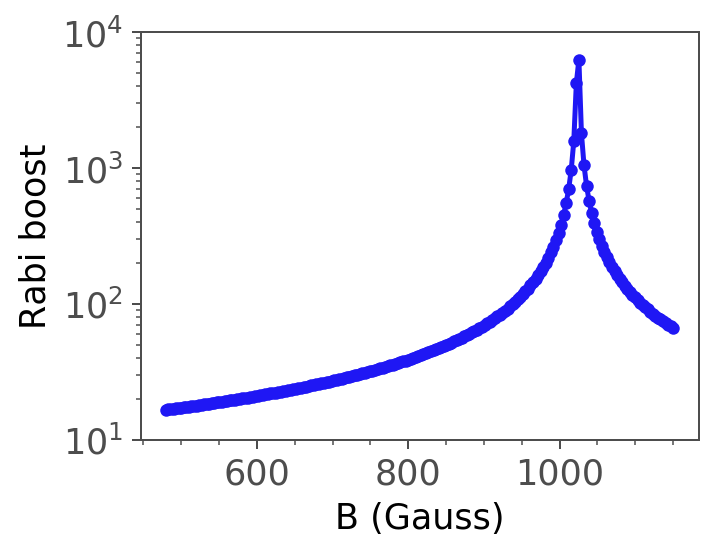

In [32]:
alpha_boost = calc_nuclear_rabi_hfs_boost(f_res_2_B_gauss(common_mw_freq), n_nuc=15)
kappa_omega_1h_15n = 1/alpha_boost * 267.522208/27.126

print(f"Nuclear Rabi boost/ 1-H/15-N ratio at common_mw_freq= {common_mw_freq/1e6:.2f} MHz: {alpha_boost:.3f} / {kappa_omega_1h_15n:.3f}")

x = np.linspace(480,1150,200)
plt.figure(figsize=(4,3))
plt.plot(x,abs(calc_nuclear_rabi_hfs_boost(x) ))
plt.yscale('log')
plt.ylim(10, 10e3)

plt.xlabel("B (Gauss)")
plt.ylabel("Rabi boost")
plt.show()

## Fit params from magnet scan: odmr

In [ ]:
### Load all odmr data from folder

In [32]:
import os.path

def get_odmr_idx(fname):
    if 'trans_index' in fname:
        fname = fname.split("trans_index")[1]
        return [int(s) for s in fname.split("_") if s.isdigit()]
    else:
        return None

def load_magnet_backmap(fname):
    with open(fname) as f:
        lines = f.readlines()
    
    backmap = []
    for l in lines:
        if "#related_intex" in l:
            data = (l.strip().split('{'))[1].split(":")
            try:
                flat_idx = int(l.strip().split('{')[0].split("_")[2].strip().strip(":"))
                #logger.debug(f"{l} -> {flat_idx}")
            except:
                raise ValueError(f"Can't parse {l}")
            x = float(data[1].split(',')[0])
            y = float(data[2].split(',')[0])
            z = data[3].split('}')[0].strip().strip("(,)")
            z = np.fromstring(z, dtype=int, sep=",")
            
            data_dict = {'x':x, 'y': y, 'flat_idx': flat_idx, 'trans_idx': z}
            backmap.append(data_dict)
    
    return backmap


def add_backmap_to_odmr(odmrs, backmap):
    for odmr in odmrs:
        for bm in backmap:
            if all(odmr['trans_idx'] == bm['trans_idx']):
                odmr['x'] = bm['x']
                odmr['y'] = bm['y']
                odmr['flat_idx'] = bm['flat_idx']
                
def do_arr_fit(odmrs, fit_method='lor_dip'):
    
     #fitter = fitlogic.make_fit_container('nb', '1d')
    fitter = pulsedmeasurementlogic.fc
    fitter.set_current_fit(fit_method)
    """
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict

    result['Position']['value']
    result['FWHM']['value']
    result['Contrast']['value']
    """
    flat_idx_max = 0
    flat_idx_min = np.inf
    xy_max = [-np.inf,-np.inf]
    xy_min = [np.inf,np.inf]
    arr_size = [0,0]

    for o in odmrs:
        data = o['data'][:,0], o['data'][:,1]

        x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
        result = result.result_str_dict
        o['fit_res'] = result

        if o['flat_idx'] > flat_idx_max:
            flat_idx_max = o['flat_idx']
        if o['x'] >= xy_max[0]:
            xy_max[0] = o['x']
            arr_size[0] = np.asarray(o['trans_idx'][0]) + 1
        if o['y'] >= xy_max[1]:
            xy_max[1] = o['y']
            arr_size[1] = np.asarray(o['trans_idx'][1]) + 1
        if o['x'] <= xy_min[0]:
            xy_min[0] = o['x']
        if o['y'] <= xy_min[1]:
            xy_min[1] = o['y']

        if o['flat_idx'] < flat_idx_max:
            flat_idx_min = o['flat_idx']
            xy_min = o['x'], o['y']
            
    return odmrs, {'arr_size': arr_size, 'xy_min': xy_min, 'xy_max': xy_max}

def create_2d(odmrs, arr_size, fit_val="Position"):
    z = np.zeros(arr_size)
    for o in odmrs:
        ix, iy = o['trans_idx'][0], o['trans_idx'][1]
        val  = o['fit_res'][fit_val]['value']
        z[ix, iy] = val
        
    z = z.transpose()
    return z

Load odmrs from magnet alignment

In [74]:
#magnet_file = r"E:\Data\2021\07\20210726\Magnet\20210727-0907-57_f-f_0_magnet_alignment_data.dat"
#inpath = r"E:\Data\2021\07\20210726\ODMR\longODMRAlign_brightPenta_20210726.1_Bz=72.1mm"
magnet_file = r"E:\Data\2021\08\20210805\Magnet\20210805-1121-53_Bz=-45mm_2_magnet_alignment_data.dat"
inpath = r"E:\Data\2021\08\20210805\ODMR\Bz=-45mm_2"
inpath = os.path.abspath(inpath)
magnet_file = os.path.abspath(magnet_file)

fnames = [inpath + "\\" + f for f in os.listdir(inpath) if os.path.isfile(os.path.join(inpath, f)) and'range' in f and '.dat' in f]
magnet_backmap = load_magnet_backmap(magnet_file)

odmr_raw = []
for f in fnames:
    odmr_raw.append({'file': f, 'trans_idx': get_odmr_idx(f), 'data':np.loadtxt(f)})

add_backmap_to_odmr(odmr_raw, magnet_backmap)

In [38]:
fnames[-1]

'E:\\Data\\2021\\08\\20210805\\ODMR\\Bz=-45mm_newFlake\\20210805-1047-55_trans_index_8_8_ODMR_data_ch0_range0.dat'

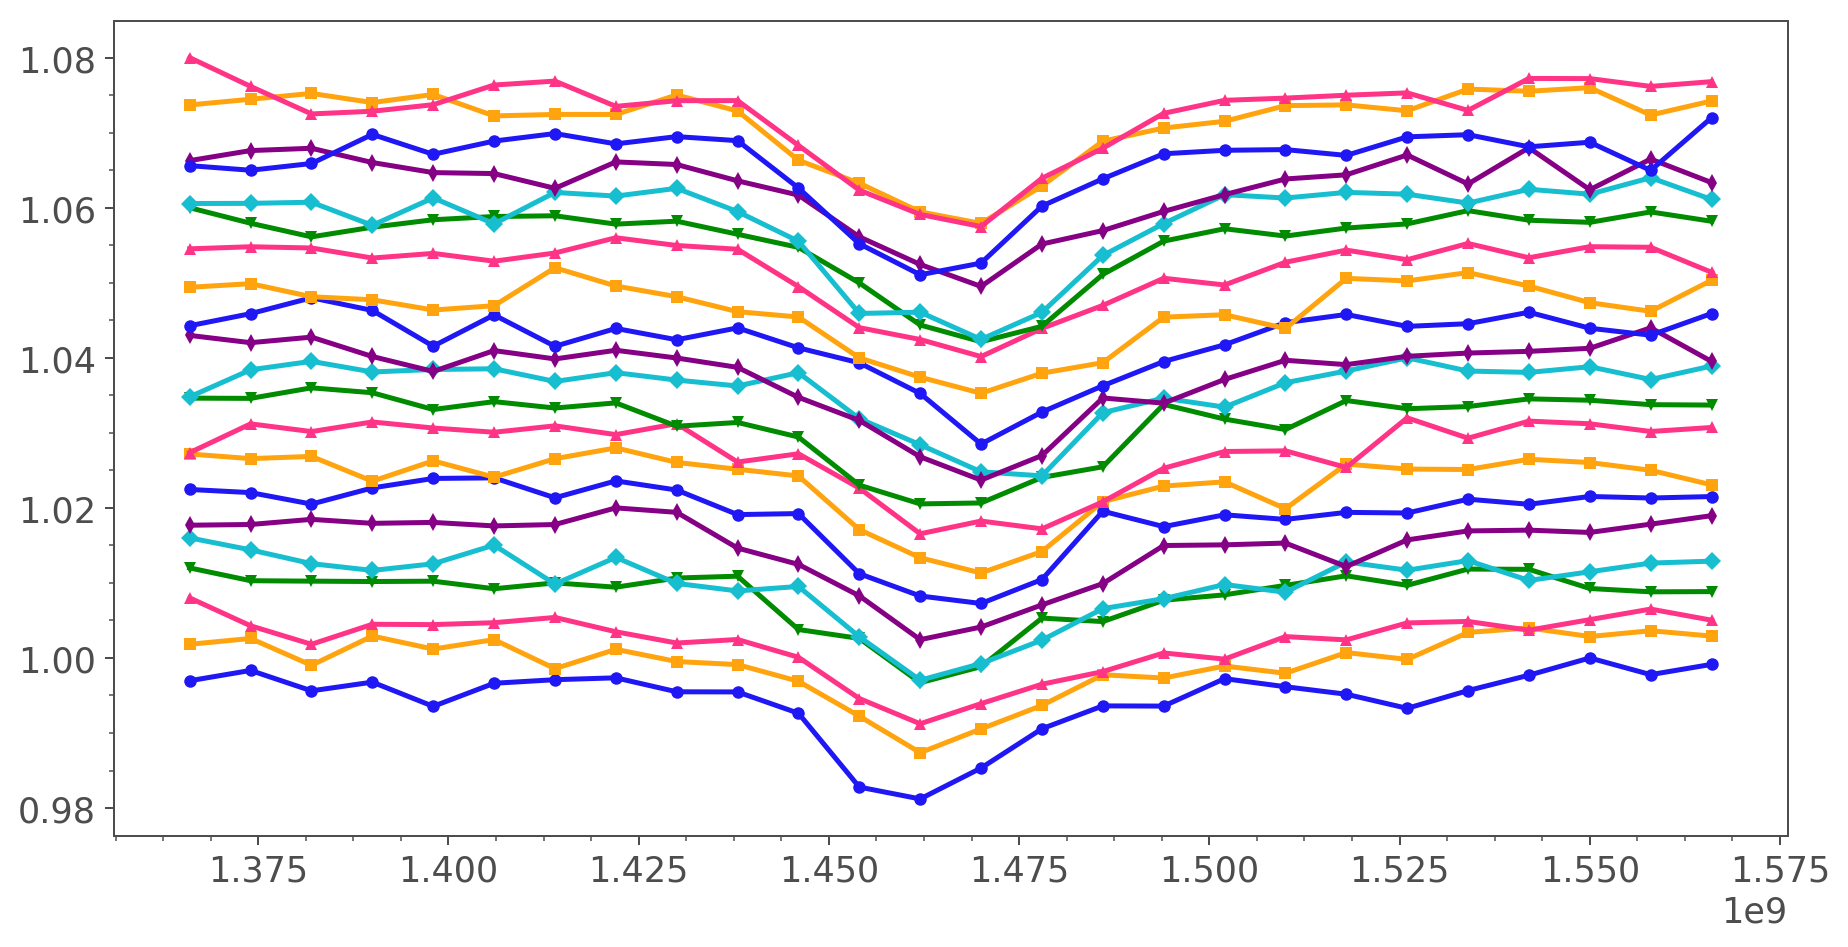

In [77]:
y_offset = 0.001

for i in np.arange(0,len(odmr_raw),4):
    f = odmr_raw[i]['data'][:,0]
    y = odmr_raw[i]['data'][:,1]
    y_norm = y / np.max(y)
    
    y_final = i*y_offset + y_norm
    plt.plot(f, y_final)

#plt.xlim([1.3e9, 1.55e9])
plt.show()

In [506]:
arr_dict

{'arr_size': [9, 9], 'xy_min': [0.0, -0.0209973], 'xy_max': [0.02, -0.0009973]}

### Fit 1x Lorentz for whole series

In [80]:
odmrs, arr_dict = do_arr_fit(odmr_raw, fit_method="lor_dip")

z_fres = create_2d(odmrs, arr_dict['arr_size'], fit_val="Position")
z_fwhm = create_2d(odmrs, arr_dict['arr_size'], fit_val="FWHM")
z_contr = create_2d(odmrs, arr_dict['arr_size'], fit_val="Contrast")

In [498]:
odmrs[0]['fit_res']

OrderedDict([('Position', {'value': 1457681081.8470829, 'error': 1693103.990721826, 'unit': 's'}), ('Contrast', {'value': 1.2840784972066044, 'error': 0.17159086222617256, 'unit': '%'}), ('FWHM', {'value': 27838173.84344558, 'error': 7816496.648940568, 'unit': 's'}), ('chi_sqr', {'value': 913715.1969355999, 'unit': ''})])

In [502]:
z_fres[0]

array([1.46088490e+09, 1.46164092e+09, 1.46016777e+09, 1.46037075e+09,
       1.46002882e+09, 1.45963322e+09, 1.45910878e+09, 1.45610985e+09,
       1.45862939e+09])

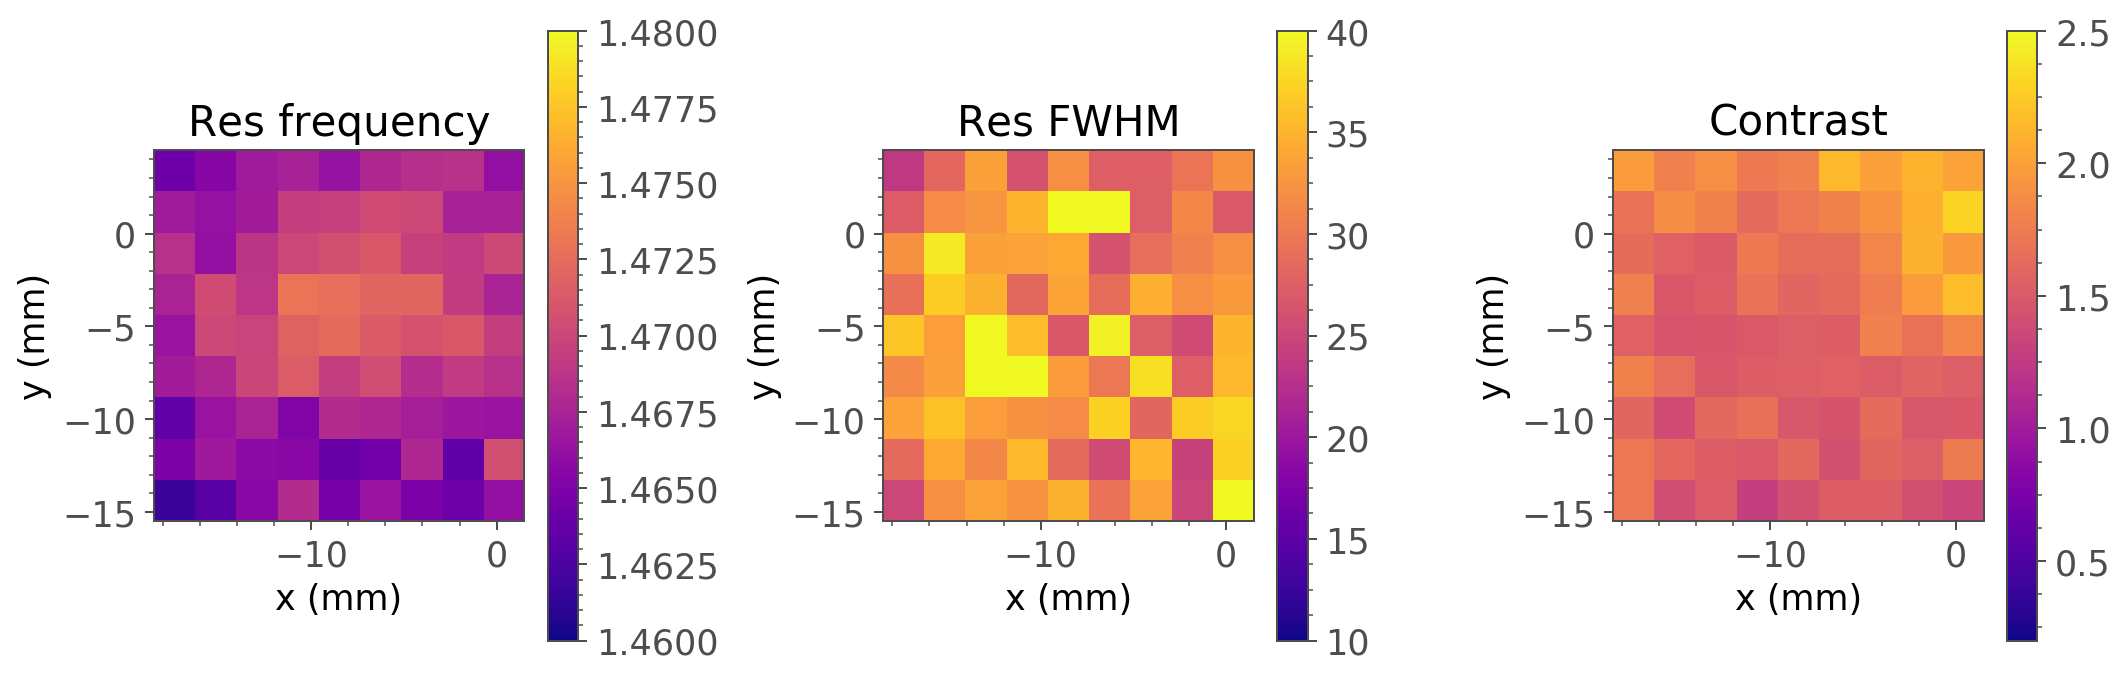

In [83]:
plt.figure(figsize=(12,4))
plt.subplot(131)

plt.imshow(z_fres/1e9, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmin=1.46,
           vmax=1.48,
           cmap='plasma')
plt.title("Res frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(132)

plt.imshow(z_fwhm/1e6, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmax=40e6/1e6,
           vmin=10e6/1e6,
           cmap='plasma')
plt.title("Res FWHM")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(133)

plt.imshow(z_contr, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmax=2.5,
           vmin=0.2,
           cmap='plasma')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.tight_layout()
plt.show()

### Fit 2x Lorentz for whole series

Note: Since the pusledmeasurement fit container is used, you can use the pulsed gui to set boundaries for the fit!

In [402]:
odmrs, arr_dict = do_arr_fit(odmr_raw, fit_method="lor_dip_2x")

z_fres0 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Position 0")
z_fres1 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Position 1")
z_fwhm0 = create_2d(odmrs, arr_dict['arr_size'], fit_val="FWHM 0")
z_fwhm1 = create_2d(odmrs, arr_dict['arr_size'], fit_val="FWHM 1")
z_contr0 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Contrast 0")
z_contr1 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Contrast 1")

z_fres = abs(z_fres0-z_fres1)
z_fwhm = abs(z_fwhm0-z_fwhm1)/2
z_contr = z_contr0/z_contr1

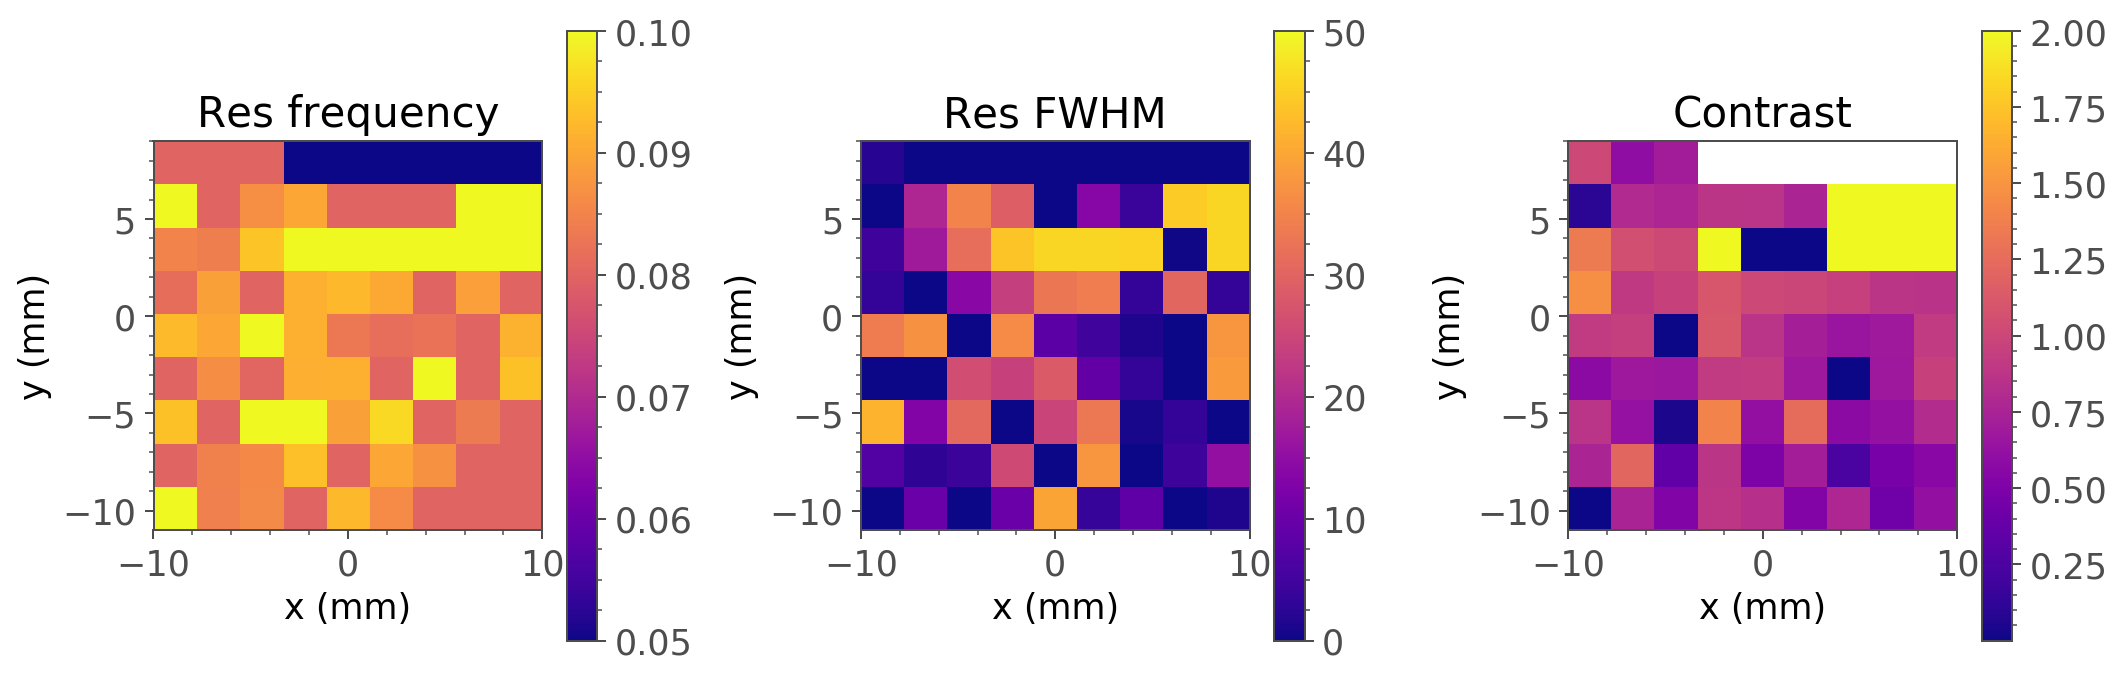

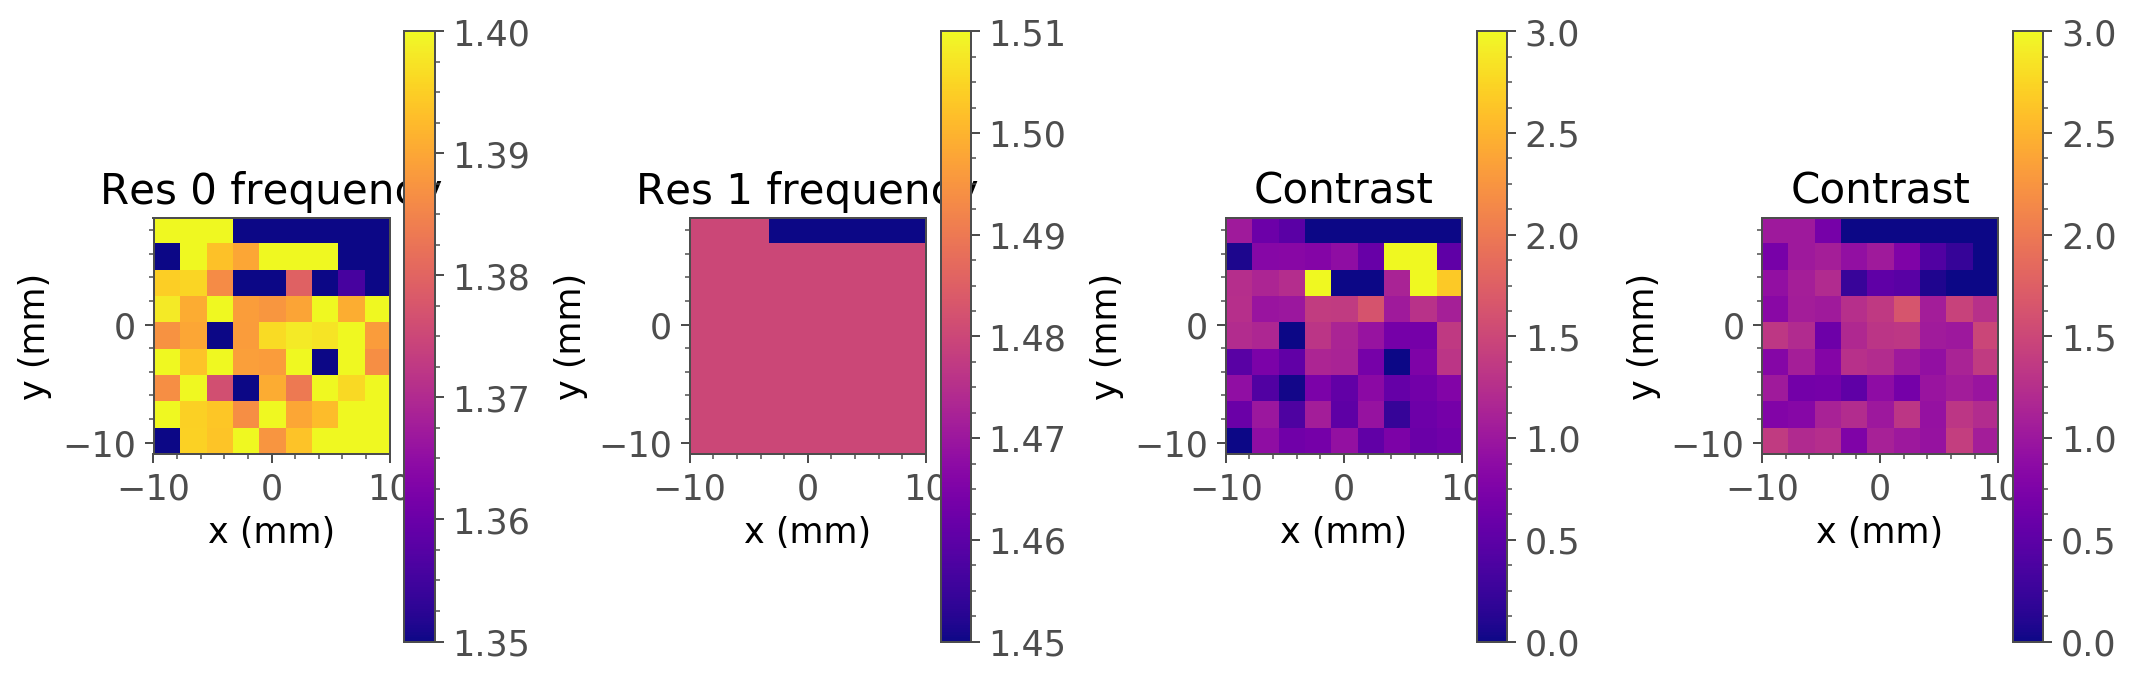

In [406]:
plt.figure(figsize=(12,4))
plt.subplot(131)

plt.imshow(z_fres/1e9, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmin=0.05,
           vmax=0.1,
           cmap='plasma')
plt.title("Res frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(132)

plt.imshow(z_fwhm/1e6, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmax=50e6/1e6, vmin=0,
           cmap='plasma')
plt.title("Res FWHM")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(133)

plt.imshow(z_contr, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmax=2,
           cmap='plasma')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.tight_layout()
plt.show()

### Detailed plot

plt.figure(figsize=(12,4))
plt.subplot(141)

plt.imshow(z_fres0/1e9, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmin=1.35,
           vmax=1.40,
           cmap='plasma')
plt.title("Res 0 frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(142)

plt.imshow(z_fres1/1e9, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmax=1.51,
           vmin=1.45,
           cmap='plasma')
plt.title("Res 1 frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(143)

plt.imshow(z_contr0, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmax=3,
           cmap='plasma')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()


plt.subplot(144)

plt.imshow(z_contr1, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           vmax=3,
           cmap='plasma')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()
plt.tight_layout()
plt.show()



### Extract fit data from running magnet logic

In [ ]:
ml = magnet_logic
mgui = magnetgui

width = np.zeros(ml._2D_data_matrix.shape)
contr = np.zeros(width.shape)
for ix,iy in np.ndindex(ml._2D_add_data_matrix.shape):
    width[ix, iy] = ml._2D_add_data_matrix[ix,iy]['Fit result']['fwhm'].value
    contr[ix, iy] = ml._2D_add_data_matrix[ix,iy]['Fit result']['Contrast'].value
#ml._2D_data_matrix = width
#mgui._update_2d_graph_data()

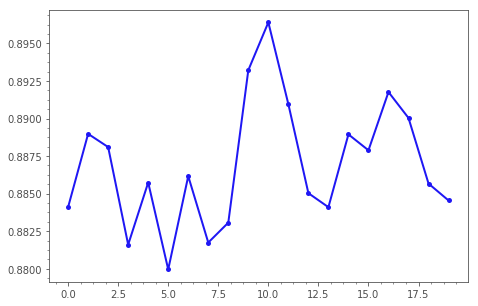

In [19]:
plt.plot(pulsedmeasurementlogic.signal_data[1])
plt.show()

#  Preperation mes

## Pulsed ODMR

In [41]:
p_scale_manual = 1
uglobals.abort.clear()

if p_scale_manual != 1:
    logger.warning("Manually reduce AWG ampl / AMP gain by a factor of {} / {}!".format(2*p_scale_manual, np.sqrt(2*p_scale_manual)))
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=50, p_scale_onlyperiod=p_scale_manual, f_step=20e3) # range ~ 1 MHz

#qmeas = setup_podmr_params(f_res=800e6, p_scale=1, f_step=4e6, n_f=100)

qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=1, f_step=3e6, n_f=100)     # wide band, ~ 150 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=1, f_step=2000e3, n_f=200)     # wide band
#qmeas = setup_podmr_params(f_res=2.88e9, p_scale=1, f_step=2000e3, n_f=200)
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=1, f_step=1000e3, n_f=20, t_wait_2=50e-6)     

#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=5, f_step=1000e3, n_f=150)     # wide band, ~ 150 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=5, f_step=500e3, n_f=75)

#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=10, f_step=500e3, n_f=75) # range ~ 5 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=10, f_step=50e3, n_f=75) # range ~ 5 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=20, f_step=1000e3, n_f=100)#, t_pi_manual=8e-6)
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=30, f_step=500e3, n_f=75)
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=40, f_step=40e3, n_f=450) # range ~ 3*6 MHz
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=60, f_step=20e3, n_f=100) # range ~ 1 MHz, lowest AWG power
#qmeas = setup_podmr_params(f_res=common_mw_freq, p_scale=60, f_step=500e3, n_f=75) # range ~ 1 MHz, lowest AWG power

run_pdomr(qmeas)

In [332]:

qmeas
#run_pdomr(qmeas)

OrderedDict([('name', 'pulsedodmr'), ('experiment', 'pulsedodmr'), ('rabi_period', 9.55e-09), ('freq_step', 3000000.0), ('num_of_points', 150), ('freq_start', 1296200000.0), ('microwave_amplitude', 0.25), ('measurement_time', 1500), ('optimize_time', None), ('fit_experiment', 'lor_dip'), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('freq_optimize_time', None), ('analysis_interval', None), ('sampling_freq', 8000000000.0), ('bin_width', 1e-09), ('wait_time', 1e-06), ('laser_delay', 9e-07), ('laser_safety', 2e-07), ('sync_channel', 'd_ch1'), ('gate_channel', ''), ('laser_channel', 'd_ch2'), ('laser_length', 3e-06), ('wait_length', 1e-06), ('trigger_length', 2e-08), ('delay_length', 8.699999999999999e-07), ('channel_amp', 1.0), ('microwave_channel', 'a_ch1'), ('optimize_channel', '/Dev1/PFI0'), ('readout_end', 3e-07), ('max_tau', 0.001), ('max_tau_start', 0.001), ('max_rabi_period', 0.001), ('min_microwave_frequency', 

## Rabi

In [44]:
uglobals.abort.clear()
qmeas = setup_rabi_params(tau_step=10e-9)   # 10e-9
#qmeas = setup_rabi_params(tau_step=250e-9, p_scale=20)
run_rabi(qmeas)

In [260]:
qmeas

OrderedDict([('name', 'rabi'), ('experiment', 'rabi'), ('tau_step', 5e-10), ('tau_start', 0.0), ('num_of_points', 50), ('microwave_frequency', 1521200000.0), ('microwave_amplitude', 0.25), ('measurement_time', None), ('optimize_time', None), ('freq_optimize_time', None), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('analysis_interval', None), ('sampling_freq', 8000000000.0), ('bin_width', 1e-09), ('wait_time', 1e-06), ('laser_delay', 9e-07), ('laser_safety', 2e-07), ('sync_channel', 'd_ch1'), ('gate_channel', ''), ('laser_channel', 'd_ch2'), ('laser_length', 3e-06), ('wait_length', 1e-06), ('trigger_length', 2e-08), ('delay_length', 8.699999999999999e-07), ('channel_amp', 1.0), ('microwave_channel', 'a_ch1'), ('optimize_channel', '/Dev1/PFI0'), ('readout_end', 3e-07), ('max_tau', 0.001), ('max_tau_start', 0.001), ('max_rabi_period', 0.001), ('min_microwave_frequency', 1), ('max_microwave_amplitude', 0.25), ('params

## Ramsey


In [425]:
qmeas

OrderedDict([('name', 'Ramsey'), ('experiment', 'ramsey_s3p'), ('rabi_period', 1.164e-07), ('microwave_frequency', 2817800000.0), ('microwave_amplitude', 0.25), ('tau_start', 5e-08), ('tau_step', 2.5e-08), ('num_of_points', 30), ('alternating', True), ('from_list', False), ('optimize_time', None), ('fit_experiment', 'sine_decay'), ('read_phases_degree', '-90, +90'), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('measurement_time', None), ('freq_optimize_time', None), ('analysis_interval', None), ('sampling_freq', 8000000000.0), ('bin_width', 4e-09), ('wait_time', 1e-06), ('laser_delay', 9e-07), ('laser_safety', 2e-07), ('sync_channel', 'd_ch1'), ('gate_channel', ''), ('laser_channel', 'd_ch2'), ('laser_length', 3e-06), ('wait_length', 1e-06), ('trigger_length', 2e-08), ('delay_length', 8.699999999999999e-07), ('channel_amp', 1.0), ('microwave_channel', 'a_ch1'), ('optimize_channel', '/Dev1/PFI0'), ('readout_end', 3e

In [491]:
tau_start = 0.05e-6
n_sweeps = 0#1e3

uglobals.abort.clear()
#qmeas = setup_ramsey_params(tau_start, n_tau=50, tau_step=50e-9, alternating=True)
qmeas = setup_ramsey_params(tau_start, n_tau=30, tau_step=25e-9, alternating=True, read_phases='-90, +90', red_readout=True)
#qmeas = setup_ramsey_params(tau_start, n_tau=100, tau_step=100e-9)     
#qmeas = setup_ramsey_params(tau_start, n_tau=120, tau_step=20e-9, alternating=True)
#qmeas = setup_ramsey_params(tau_start, n_tau=200, tau_step=250e-9)      # 75ns: res like mfl
#qmeas = setup_ramsey_params(tau_start, n_tau=400, tau_step=50e-9)     # high res    
#qmeas = setup_ramsey_params(tau_start, n_tau=400, tau_step=100e-9)     # high res  
x, z = run_ramsey(qmeas, n_sweeps_stop=n_sweeps)
z_binary = 0 #majority_vote(z[0], z_thres=common_mfl_z_thres)

logger.info("Ramsey with offset {} MHz, {} sweeps: {} -> {}".format(common_mw_ramsey_offset/1e6, n_sweeps, z, z_binary))


In [479]:
qmeas

OrderedDict([('name', 'Ramsey'), ('experiment', 'ramsey_s3p'), ('t_laser_init', 3e-06), ('laser_read_ch', 'd_ch3'), ('rabi_period', 1.164e-07), ('microwave_frequency', 2817800000.0), ('microwave_amplitude', 0.25), ('tau_start', 5e-08), ('tau_step', 2.5e-08), ('num_of_points', 30), ('alternating', True), ('from_list', False), ('optimize_time', None), ('fit_experiment', 'sine_decay'), ('read_phases_degree', '-90, +90'), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('measurement_time', None), ('freq_optimize_time', None), ('analysis_interval', None), ('sampling_freq', 8000000000.0), ('bin_width', 4e-09), ('wait_time', 1e-06), ('laser_delay', 9e-07), ('laser_safety', 2e-07), ('sync_channel', 'd_ch1'), ('gate_channel', ''), ('laser_channel', 'd_ch2'), ('laser_length', 5e-07), ('wait_length', 1e-06), ('trigger_length', 2e-08), ('delay_length', 8.699999999999999e-07), ('channel_amp', 1.0), ('microwave_channel', 'a_ch1'), (

## Hahn


In [195]:
he_tau_step = 125e-9
he_n_tau = 150
#he_n_tau = 50

logger.info(f"Tau max= {he_tau_step*he_n_tau}")

In [201]:
uglobals.abort.clear()

qmeas = setup_hahn_params(tau_start=10e-9, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
#qmeas = setup_hahn_params(tau_start=14e-6, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
run_generic(qmeas)

## XY 8 

tau sweep

In [95]:
#tau_start = 0.2e-6
tau_start = 0.100e-6

uglobals.abort.clear()
# narrow resonance NV M17
qmeas = setup_xy8_tausweep_params(tau_start, n_tau=50, tau_step=100e-9, xy8_order=4, alternating=True)

#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=10, tau_step=25e-9, xy8_order=800, alternating=True)


# larger sweeps
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=10e-9, xy8_order=4, alternating=True) 
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=3e-9, xy8_order=4, alternating=True) 
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=250, tau_step=20e-9, xy8_order=4, alternating=True)
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=5e-9, xy8_order=8, alternating=True) 

run_xy8_tausweep(qmeas)

n sweep

In [21]:
tau = 300e-9#440.0e-9
tau = 441.6e-9

uglobals.abort.clear()
#qmeas = setup_xy8_nsweep_params(tau, n_n=25, xy8_start=4, xy8_step=1, alternating=True)
qmeas = setup_xy8_nsweep_params(tau, n_n=15, xy8_start=4, xy8_step=100, alternating=True)  # long t_evol, mem limit
#qmeas = setup_xy8_nsweep_params(tau, n_n=25, xy8_start=1, xy8_step=1, alternating=True)  

run_xy8_nsweep(qmeas)

In [ ]:
a few xy8 tau sweeps

In [54]:
uglobals.abort.clear()

tau_start = 0.5e-6
xy_orders = np.arange(5, 16, 1)

for i, o in enumerate(xy_orders):
    if uglobals.abort.is_set():
        break
    try:
        #pass
        #"""
        laser_on()
        time.sleep(1)
        optimize_position()
        optimize_position()
        laser_off()
        #"""
    except Exception as e:
        logger.warning("auto XY8 run {}, skipping failed tracking: {}".format(i, str(e)))
    if uglobals.abort.is_set():
        break
        
    qmeas = setup_xy8_tausweep_params(tau_start, n_tau=50, tau_step=20e-9, xy8_order=o, alternating=True)     
    qmeas['measurement_time'] = 180
    run_xy8_tausweep(qmeas)

# NV - Pentacene IA

## DEER

In [207]:
common_he_tau = 1e-6

### Spectrum

In [303]:
uglobals.abort.clear()

f_center = 1.407e9
f_center = 1.5e9
#f_center = 1.305e9
#f_center = 0.735e9
#f_center = 0.850e9
#t_pi_fix = 6000e-9   # if already calibrated by DEER Rabi
t_pi_fix = None    # else

# wide band
#qmeas = setup_deer_f_params(f_center, f_step=5e6, n_f=100, two_deer_pi=True,
#                            pi_len=t_pi_fix)
#qmeas = setup_deer_f_params(f_center, f_step=3e6, n_f=150, two_deer_pi=True,
#                            he_tau=common_he_tau, pi_len=t_pi_fix, read_phases='-90, 90')
qmeas = setup_deer_f_params(f_center, f_step=6e6, n_f=75, two_deer_pi=True,
                            he_tau=common_he_tau, pi_len=t_pi_fix, read_phases='0, 180')
#qmeas = setup_deer_f_params(f_center, f_step=6e6, n_f=75, two_deer_pi=False,
#                            he_tau=common_he_tau, pi_len=t_pi_fix, read_phases='-90, 90', deer_ampl=0.25/5.)
#qmeas = setup_deer_f_params(f_center, f_step=1e6, n_f=200, two_deer_pi=False,
#                            pi_len=t_pi_fix)
# high res
#qmeas = setup_deer_f_params(f_center, f_step=500e3, n_f=75, two_deer_pi=True,
#                           he_tau=common_he_tau, pi_len=t_pi_fix)
# wide band
#qmeas = setup_deer_f_params(f_center, f_step=2000e3, n_f=120, two_deer_pi=True,
#                           he_tau=300e-9)

run_deer_f(qmeas)

In [89]:
qmeas

OrderedDict([('name', 'deer_spectrum'), ('freq_step', 2000000.0), ('num_of_points', 250), ('freq_start', 750000000.0), ('measurement_time', 150000), ('optimize_time', None), ('alternating', True), ('two_deer_pi', True), ('he_tau', 3e-07), ('deer_amp', 0.25), ('pi_len', 3.4e-08)])

### DEER Rabi

In [267]:
uglobals.abort.clear()

f_deer = 1.3989e9
f_deer = 1.9e9
#f_deer = 0.737e9


qmeas = setup_deer_rabi_params(f_deer, tau_start=5e-9, tau_step=25e-9, n_tau=40, he_tau=common_he_tau, 
                               two_deer_pi=False, read_phases='-90, 90', deer_ampl=0.25)
#qmeas = setup_deer_rabi_params(f_deer, tau_start=27.5e-9, tau_step=1e-9, n_tau=1, he_tau=common_he_tau)
#qmeas = setup_deer_rabi_params(f_deer, tau_start=5e-9, tau_step=4e-9, n_tau=80, he_tau=300e-9, two_deer_pi=True)

#qmeas = setup_deer_rabi_params(f_deer, tau_start=5e-9, tau_step=4e-9, n_tau=80, he_tau=300e-9, two_deer_pi=False)
run_deer_rabi(qmeas)


In [197]:
qmeas

OrderedDict([('name', 'deer_rabi'), ('tau_start', 5e-09), ('num_of_taus', 80), ('tau_step', 4e-09), ('measurement_time', 99999), ('optimize_time', None), ('he_tau', 3e-07), ('two_deer_pi', False), ('deer_amp', 0.25), ('deer_freq', 820000000.0), ('alternating', True), ('experiment', 'deer_rabi'), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('freq_optimize_time', None), ('analysis_interval', None), ('sampling_freq', 8000000000.0), ('bin_width', 1e-09), ('wait_time', 1e-06), ('laser_delay', 9e-07), ('laser_safety', 2e-07), ('sync_channel', 'd_ch1'), ('gate_channel', ''), ('laser_channel', 'd_ch2'), ('laser_length', 3e-06), ('wait_length', 1e-06), ('trigger_length', 2e-08), ('delay_length', 8.699999999999999e-07), ('channel_amp', 1.0), ('microwave_channel', 'a_ch1'), ('optimize_channel', '/Dev1/PFI0'), ('readout_end', 3e-07), ('max_tau', 0.001), ('max_tau_start', 0.001), ('max_rabi_period', 0.001), ('min_microwave_freq

### time DEER

In [188]:
uglobals.abort.clear()

f_deer = 1.407e9
#f_deer = 1.00e9
f_deer = 1.3795e9
f_deer = 0.820e9
deer_rabi_period = 57e-9

# wide band
#qmeas = setup_deer_f_params(f_center, f_step=5e6, n_f=50, two_deer_pi=True)
# high res

qmeas = setup_deer_params(f_deer, tau_start=5e-9, tau_step=6e-9, n_tau=50, 
                      he_tau=common_he_tau, second_rabi_period=deer_rabi_period,
                      two_deer_pi=True)
#qmeas = setup_deer_params(f_deer, tau_start=282e-9, tau_step=0e-9, n_tau=1, 
#                      he_tau=common_he_tau, second_rabi_period=deer_rabi_period,
#                      two_deer_pi=True)
#qmeas['wait_time'] = 1e-6
qmeas['two_deer_pi'] = True

run_deer(qmeas)

#qmeas['name'] = 'deer_pi_start'
#run_deer_pi_start(qmeas)

In [215]:
qmeas

OrderedDict([('name', 'DEER'), ('tau_start', 5e-09), ('num_of_points', 40), ('tau_step', 2e-09), ('measurement_time', 99999), ('optimize_time', None), ('he_tau', 3e-07), ('two_deer_pi', True), ('deer_amp', 0.25), ('deer_freq', 1398900000.0), ('second_rabi_period', 2e-07), ('alternating', True), ('wait_time', 1e-06)])

### T1 like DEER

If the second electron spin is polarized by the laser pulse and its T1 << T1(NV), we can do the following experiment: increasing the t_wait of the NV initialization won't hurt the NV sensor too much. However, the second electron spin starts to decay right after the laser pulse. If it's an ensemble spin, the lowered polarization due to its T1 decay will lower the effective coupling to the sensor. Thus, the frequency observed in the FFT of deer should lower

In [38]:
t_waits = np.linspace(1e-6, 20e-6, 10)[1:]#[::-1]
uglobals.abort.clear()

for t in t_waits:
    qmeas = setup_deer_params(f_deer, tau_start=5e-9, tau_step=2e-9, n_tau=40, 
                          he_tau=300e-9, second_rabi_period=deer_rabi_period,
                          two_deer_pi=True)
    qmeas['wait_time'] = t
    
    qmeas['n_sweeps'] = 1e6
    qmeas['name'] = 'deer_pi_start'

    qmeas['save_tag'] = f'DEER_pi_start_t_wait={t}'

    #run_deer(qmeas, save_tag=qmeas['save_tag'])
    qmeas['two_deer_pi'] = False
    run_deer_pi_start(qmeas, save_tag=qmeas['save_tag'])

### pODMR DEER pi

In [62]:
qmeas

OrderedDict([('name', 'pulsedodmr_deer_pi'), ('experiment', 'pulsedodmr_deer_pi'), ('rabi_period', 5.64e-07), ('freq_step', 500000.0), ('num_of_points', 75), ('freq_start', 1431550000.0), ('microwave_amplitude', 0.004166666666666667), ('deer_amplitude', 0.25), ('measurement_time', 1500), ('optimize_time', None), ('fit_experiment', 'lor_dip'), ('f_mw_deer', 737000000.0), ('t_pi_deer', 3.4e-08)])

In [71]:
f_deer = 0.737e9
#f_deer = 1.2e9   # off-resonant dummy frequency
t_pi_deer = 68e-9 / 2

uglobals.abort.clear()

qmeas = setup_podmr_deer_pi_params(f_res=common_mw_freq, f_deer=f_deer, t_pi_deer=t_pi_deer,
                           p_scale=60, f_step=500e3, n_f=150) # range ~ 1 MHz, lowest AWG power

run_generic(qmeas)

### Ramsey DEER pi

Ramsey with a pi pulse on the 2nd electron spin right after the 1st pi/2 on the NV.

In [71]:
f_deer = 0.737e9
f_deer = 1.2e9   # off-resonant dummy frequency
t_pi_deer = 68e-9 / 2


uglobals.abort.clear()
#qmeas = setup_ramsey_deer_pi_params(f_deer, t_pi_deer, 
#                                tau_start=50e-9, n_tau=50, tau_step=20e-9,
#                                alternating_mode=DeerAltModes.NVPi3Half)
qmeas = setup_ramsey_deer_pi_params(f_deer, t_pi_deer, 
                                tau_start=50e-9, n_tau=160, tau_step=10e-9,
                                alternating_mode=DeerAltModes.DeerPiOff_plus_NVPi3Half,
                                two_deer_pi=True)


run_generic(qmeas)

In [59]:
f_deer

1200000000.0

# NV - Nuclear spins IA

## Penta ISE + NV Ramsey + RF DD

In [557]:
uglobals.abort.clear()
qmeas = setup_ise_ramsey_dd_params(tau=350e-9, n_tau=5, n_order_dd=1, f_rf=1e6, t_pi_rf=2e-6, amp_rf=0.01, rf_ch='a_ch2',
                                   dd_type=DDMethods.XY8, t_laser=1e-6, mw_sweep_speed=3e12, f_ise_res=2e9, df_mw_sweep=10e6, amp_mw_sweep=0.25,
                                   alternating=True, autosave=False, red_readout=True)
qmeas

OrderedDict([('name', 'ise+ramsey+rf_dd'), ('experiment', 'pol_ramsey_rf_dd'), ('t_laser_init', 3e-06), ('laser_read_ch', 'd_ch3'), ('tau', 3.5e-07), ('n_tau', 5), ('n_order_pi_rf', 1), ('dd_type', <DDMethods.XY8: [0.0, 90.0, 0.0, 90.0, 90.0, 0.0, 90.0, 0.0]>), ('f_rf', 1000000.0), ('t_pi_rf', 2e-06), ('amp_rf', 0.01), ('rf_channel', 'a_ch2'), ('t_laser', 1e-06), ('mw_sweep_speed', 3000000000000.0), ('amp_mw_sweep', 0.25), ('f_ise_res', 2000000000.0), ('df_mw_sweep', 10000000.0), ('measurement_time', 99999), ('optimize_time', None), ('autosave_s', False), ('alternating', True)])

In [560]:
run_generic(qmeas)

# Auto pilot multiple NVs

In [335]:
poimanagerlogic.poi_names[16:]

['NV_20210721_1', 'NV_20210721_2', 'NV_20210721_3', 'NV_20210721_4', 'NV_20210721_5', 'NV_20210721_6', 'NV_20210721_7', 'NV_20210721_8', 'NV_20210721_9']

In [338]:
# In order to stop the automized measurement insert pulsedmasterlogic.break_variable = True into manager
import copy
uglobals.abort.clear()
qmeas=OrderedDict()
# Either specify a list with points of interest or take all poi from the current ROI (use empty list)
#qmeas['list_pois'] = []
qmeas['list_pois'] = poimanagerlogic.poi_names[16:]
qmeas['generate_new'] = True
qmeas['no_optimize'] = True
logger.info("Autopilot is taking of for pois {}".format(qmeas['list_pois']))
# Create another dictionary for the experiments and parameters
autoexp=OrderedDict()
# Then specify all necessary experiment and parameters


# optional parameters 
qmeas['optimize_between_experiments'] = False


#Experiment1
# need to specify for the automatic update
f_step_odmr_fine=100e3
n_f_odmr_fine=100

#"""
experiment1 = 'pODMR_coarse'
qexp =  setup_podmr_params(f_res=common_mw_freq, p_scale=30, f_step=500e3, n_f=100)

qexp['type'] = 'pulsedodmr'
qexp['measurement_time'] = 2*60
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_dip'
qexp['fit_parameter'] = 'Position'
qexp['update_parameters'] = {'Rabi': 'microwave_frequency',
                             'Hahn_Echo': 'microwave_frequency',
                             'pODMR_fine': {'target_name': 'freq_start',
                                            'func': f"_x_ - 0.5*({f_step_odmr_fine}*{n_f_odmr_fine})"}
                            }
autoexp[experiment1] = copy.deepcopy(qexp)

#"""
#Experiment2
#"""

experiment2 = 'Rabi'
qexp = setup_rabi_params(tau_step=2.5*common_rabi_period/50)
qexp['type'] = 'rabi'
qexp['measurement_time'] = 2*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {'ramsey': 'rabi_period',
                             'Hahn_Echo': 'rabi_period',
                             'pODMR_fine': 'rabi_period'}  # feed forware parameters

autoexp[experiment2] = copy.deepcopy(qexp)


#"""
#Experiment2
#"""

experiment3 = 'Hahn_Echo'
#qexp = setup_hahn_params(tau_start=10e-9, n_tau=50, tau_step=0.2e-6, alternating=True)
#
#qexp = setup_hahn_params(tau_start=10e-9, n_tau=150, tau_step=125e-9, alternating=True)
qexp = setup_hahn_params(tau_start=10e-9, n_tau=75, tau_step=500e-9, alternating=True)
qexp['type'] = 'hahnecho'
qexp['measurement_time'] = 10*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'decay'
qexp['fit_parameter'] = 'Lifetime'

autoexp[experiment3] = copy.deepcopy(qexp)




#Experiment4
"""
experiment4 = 'ramsey'
qexp = setup_ramsey_params(tau_start=50e-9, n_tau=400, tau_step=50e-9)  # res= 50 kHz 
qexp['type'] = 'ramsey'
qexp['measurement_time'] = 120
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
qexp['fit_experiment'] = 'double_sine_decay'
autoexp[experiment4] = copy.deepcopy(qexp)

"""

"""
experiment3 = 'pODMR_fine'
qexp =  setup_podmr_params(f_res=common_mw_freq, p_scale=15, f_step=100e3, n_f=100)

qexp['type'] = 'pulsedodmr'
qexp['measurement_time'] = 15
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_n15'
qexp['fit_parameter'] = 'Position'
qexp['update_parameters'] = {'Rabi': 'microwave_frequency',
                             'pODMR_fine':'microwave_frequency',
                             'xy8': 'microwave_frequency',
                             'xy8_2': 'microwave_frequency'}

autoexp[experiment3] = copy.deepcopy(qexp)
"""
# create another dictionary for the parameters
"""
autoexp[experiment1]=OrderedDict()
autoexp[experiment1]['type'] = 'pulsed_odmr'
autoexp[experiment1]['name'] = experiment1
autoexp[experiment1]['rabi_period'] = common_rabi_period
autoexp[experiment1]['freq_start'] = common_mw_freq -25e6
autoexp[experiment1]['freq_step'] = 1e6
autoexp[experiment1]['num_of_points'] = 50
autoexp[experiment1]['microwave_amplitude'] = common_mw_amp
autoexp[experiment1]['measurement_time'] = 10
autoexp[experiment1]['optimize_time'] = None
autoexp[experiment1]['freq_optimize_time'] = None
autoexp[experiment1]['generate_new'] = False
autoexp[experiment1]['meas_type'] = conventional_measurement
autoexp[experiment1]['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
autoexp[experiment1]['fit_experiment'] = 'lor_neg'
autoexp[experiment1]['fit_parameter'] = 'Position'
autoexp[experiment1]['update_parameters'] = {'Rabi': 'microwave_frequency', 'xy8': 'microwave_frequency', 'xy8_2': 'microwave_frequency'}
"""

# broken to add experiments in loop
#autoexp[experiment1] = copy.deepcopy(qexp)
#"""

#Experiment2
"""
experiment2 = 'Rabi'
qexp = setup_rabi_params(tau_step=10e-9)
qexp['type'] = 'rabi'
qexp['measurement_time'] = 30
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {'ramsey': 'rabi_period'}  # feed forware parameters
autoexp[experiment2] = copy.deepcopy(qexp)

#Experiment3
experiment3 = 'ramsey'
qexp = setup_ramsey_params(tau_start=50e-9, n_tau=400, tau_step=50e-9)  # res= 50 kHz 
qexp['type'] = 'ramsey'
qexp['measurement_time'] = 120
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
qexp['fit_experiment'] = 'double_sine_decay'
autoexp[experiment3] = copy.deepcopy(qexp)


"""

laser_off()
do_automized_measurements(qm_dict=qmeas, autoexp=autoexp)




In [320]:
poimanagerlogic.poi_names[-1]

'poi_20210720135257025577'

In [434]:
qmeas

OrderedDict([('name', 'hahnecho'), ('rabi_period', 5.35e-08), ('microwave_frequency', 2776000000.0), ('microwave_amplitude', 0.25), ('tau_start', 1e-08), ('tau_step', 2e-07), ('num_of_points', 50), ('alternating', True), ('optimize_time', None), ('fit_experiment', 'exp')])